对于深度学习问题，我们通常会先定义损失函数。\
一旦我们有了损失函数，我们就可以使用优化算法来尝试最小化损失。\
在优化中，损失函数通常被称为优化问题的目标函数。\
按照传统惯例，大多数优化算法都关注的是最小化。\
如果我们需要最大化目标，在目标函数前加负号即可。

## 1 优化的目标

尽管优化提供了一种最大限度地减少深度学习损失函数的方法，但本质上，优化和深度学习的目标是根本不同的。\
前者主要关注的是最小化目标，后者则关注在给定有限数据量的情况下寻找合适的模型。\
在 4.4节中，我们详细讨论了这两个目标之间的区别。\
例如，训练误差和泛化误差通常不同：由于优化算法的目标函数通常是基于训练数据集的损失函数，因此优化的目标是减少训练误差。\
但是，深度学习（或更广义地说，统计推断）的目标是减少泛化误差。\
为了实现后者，除了使用优化算法来减少训练误差之外，我们还需要注意过拟合。

In [1]:
%matplotlib inline
import numpy as np
import torch
from D2L import d2l

为了说明上述不同的目标，引入两个概念风险和经验风险。\
如 4.9.3节所述，经验风险是训练数据集的平均损失，而风险则是整个数据群的预期损失。\
下面我们定义了两个函数：风险函数f和经验风险函数g。\
假设我们只有有限的训练数据。因此，这里的g不如f平滑。

In [2]:
def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

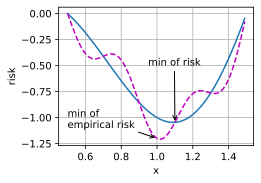

In [3]:
def annotate(text, xy, xytext): #@save
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of\nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))
d2l.plt.show()

## 2 深度学习中的优化挑战

在 3.1节中，我们区分了优化问题中的解析解和数值解。\
在深度学习中，大多数目标函数都很复杂，没有解析解。\
相反，我们必须使用数值优化算法。\
深度学习优化存在许多挑战。\
其中最令人烦恼的是局部最小值、鞍点和梯度消失。

### 局部最小值

对于任何目标函数 $f(x)$，如果在x处对应的 $f(x)$ 值小于在x附近任意其他点的f (x)值，那么f (x)可能是局部最小值。\
如果f (x)在x处的值是整个域中目标函数的最小值，那么f (x)是全局最小值。\
例如，给定函数\
$$
f(x) = x · \cos(πx)\text{ for }− 1.0 ≤ x ≤ 2.0,\tag{11.1.1}
$$

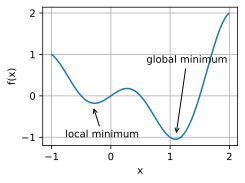

In [4]:
x = torch.arange(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x), ], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

深度学习模型的目标函数通常有许多局部最优解。\
当优化问题的数值解接近局部最优值时，随着目标函数解的梯度接近或变为零，通过最终迭代获得的数值解可能仅使目标函数局部最优，而不是全局最优。\
只有一定程度的噪声可能会使参数跳出局部最小值。\
事实上，这是小批量SGD的有利特性之一。在这种情况下，小批量上梯度的自然变化能够将参数从局部极小值中跳出。

### 鞍点

鞍点（saddle point）是指函数的所有梯度都消失但既不是全局最小值也不是局部最小值的任何位置。\
考虑这个函数 $f(x) = x^3$。\
它的一阶和二阶导数在x = 0时消失。这时优化可能会停止，尽管它不是最小值。

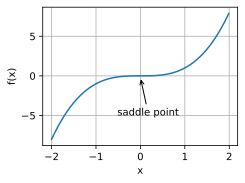

In [5]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x ** 3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

较高维度的鞍点甚至更加隐蔽。\
考虑这个函数 $f(x, y) = x^2 − y^2$。\
它的鞍点为(0, 0)。\
这是关于y的最大值，也是关于x的最小值。

Text(0.5, 0.5, 'y')

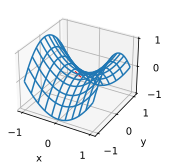

In [7]:
x, y = torch.meshgrid(
torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2
ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y')

我们假设函数的输入是k维向量，其输出是标量，因此其Hessian矩阵（也称黑塞矩阵）将有k个特征值（参考特征分解的在线附录125)。\
函数的解可能是局部最小值、局部最大值或函数梯度为零位置处的鞍点：
- 当函数在零梯度位置处的Hessian矩阵的特征值全部为正值时，我们有该函数的局部最小值；
- 当函数在零梯度位置处的Hessian矩阵的特征值全部为负值时，我们有该函数的局部最大值；
- 当函数在零梯度位置处的Hessian矩阵的特征值为负值和正值时，我们有该函数的一个鞍点。

对于高维度问题，至少部分特征值为负的可能性相当高。这使得鞍点比局部最小值更有可能出现。\
简而言之，凸函数是Hessian函数的特征值永远不为负值的函数。不幸的是，大多数深度学习问题并不属于这一类。尽管如此，它还是研究优化算法的一个很好的工具。

### 梯度消失

可能遇到的最隐蔽问题是梯度消失。回想一下我们在 4.1.2节中常用的激活函数及其衍生函数。\
例如，假设我们想最小化函数 $f(x) = \tanh(x)$，然后我们恰好从x = 4开始。\
正如我们所看到的那样，f 的梯度接近零。更具体地说，$f′(x) = 1 − \tanh^2(x)$，因此是 $f′(4) = 0.0013$。\
因此，在我们取得进展之前，优化将会停滞很长一段时间。\
事实证明，这是在引入ReLU激活函数之前训练深度学习模型相当棘手的原因之一。

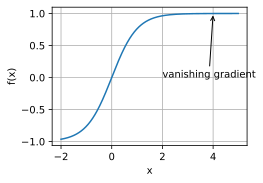

In [8]:
x = torch.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [torch.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))